# Wright-Fisher Simulations

*in progress*

## Imports / configuration

In [1]:
%load_ext autoreload

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pb
import GPy as gp

%autoreload 2

# import helper functions
import sys
sys.path.append("src")
import simulator as sim

# configure plot style
sns.set_context("poster")
sns.set_style("whitegrid", 
              {"axes.facecolor": "1.0", 
               "axes.edgecolor": "0.5",
               "grid.linestyle": "-",
              })
plt.style.use("whitegrid.mplstyle")

## Simulation

Simulate allele frequencies

In [3]:
p = 10000 # number of SNPs
n_e = 5000 # effective population size
max_gen = 700 # number of generations to sim 700*25 17500
F = sim.simulate_frequencies(p, n_e, max_gen)

Simulate genotypes

In [4]:
n = 20 # number of sampled individuals

# sampled time points
t = np.sort(np.random.choice(range(F.shape[0]), size=n, replace=False))
X = sim.simulate_genotypes(t, F)

Simulate reads

In [5]:
eps = .01 # error rate
lamb = .5 # average coverage
Y, C = sim.simulate_reads(X, eps, lamb)

Plot a hist of the coverage distribution for a the first individual

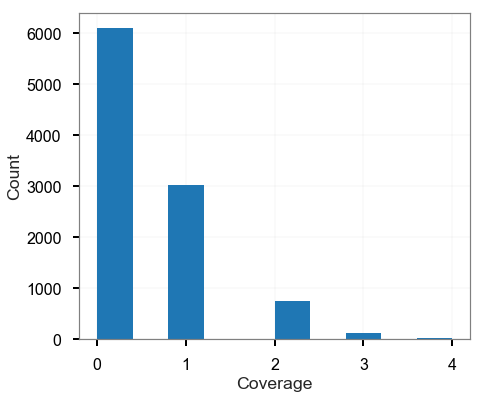

In [8]:
plt.hist(C[0,:]);
plt.xlabel("Coverage");
plt.ylabel("Count");

Plot some example trajectories

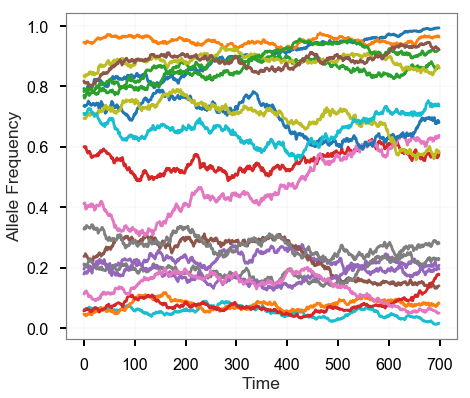

In [9]:
idx = np.sort(np.random.choice(range(p), size=20, replace=False))
for j in idx:
    plt.plot(range(max_gen), F[:,j])
    
plt.xlabel("Time");
plt.ylabel("Allele Frequency");

Compute the population heterozygosity

In [10]:
H = 2 * F * (1 - F) # for all time points
h_true = np.sum(H, axis=1) / p
h = h_true[t] # for sampled time points

Compute an estimate of heterozygosity from genotypes

In [11]:
h_hat = sim.est_het_geno(X)

Plot population heterozygosity against time

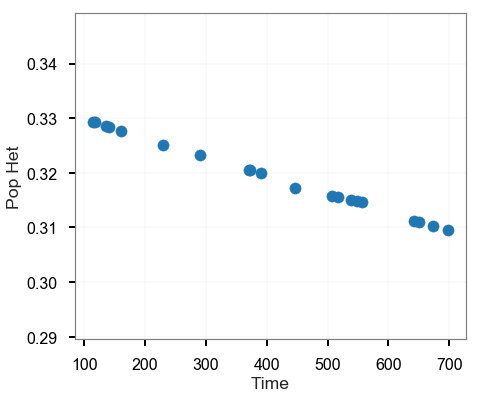

In [12]:
plt.scatter(t, h)
plt.xlabel("Time");
plt.ylabel("Pop Het");

Plot estimated heterozygosity against time

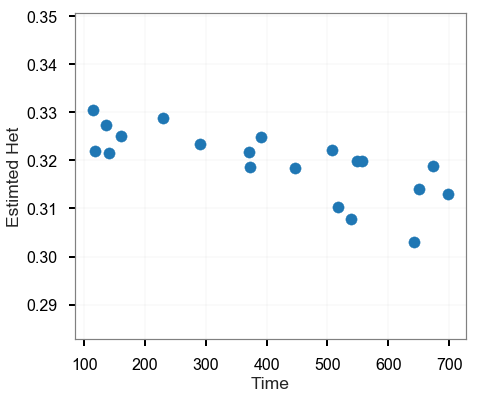

In [13]:
plt.scatter(t, h_hat)
plt.xlabel("Time");
plt.ylabel("Estimted Het");

## Inference

Fit a Gaussian Process regression model with a Matern kernal. We use an emprical Bayes approach where the marginal likelihood is maximized to estimate hyper parameters of the covariance kernal and then posterior is then analytically computed ...

In [20]:
#kern = gp.kern.Matern52(1) # set the kernal
kern = gp.kern.Exponential(1)
model = gp.models.GPRegression(t[:,None], h_hat[:,None], kern) # set the model

# fixing the noise variance
h_mod = H[-1,:]
sigma2_e = np.sum(h_mod * (1. - h_mod)) / p**2
model[".*Gaussian_noise"] = sigma2_e 
model[".*Gaussian_noise"].fix()

# fixing the lengthscale
#model[".*lengthscale"] = 12 * n_e
#model[".*lengthscale"].fix()

In [21]:
%%time
model.optimize()
model_df = pd.DataFrame({"Posterior Mean": model.posterior.mean[:,0], "Pop Het":h, "Est Het": h_hat})

CPU times: user 64.8 ms, sys: 1.47 ms, total: 66.3 ms
Wall time: 66.4 ms


 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:212: RuntimeWarning:invalid value encountered in multiply


Fitting this is incredibly quick!

## Critique

Here is a plot of the posterior mean and variance output by the analytical posterior of the Gaussian Process model

 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


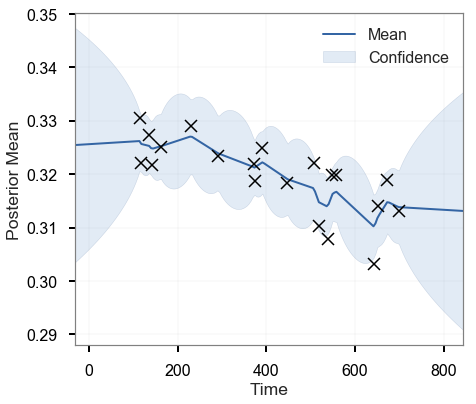

In [22]:
model.plot_f();
plt.xlabel("Time");
plt.ylabel("Posterior Mean");
plt.plot(t, h_hat,'kx', mew=1.5);

Here is a plot of the posterior mean against the population heterozygosity

0.9464419533810527

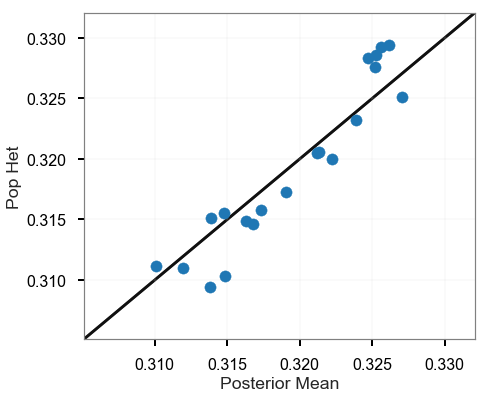

In [23]:
sim.plot_xy(model_df["Posterior Mean"], model_df["Pop Het"])
plt.xlabel("Posterior Mean");
plt.ylabel("Pop Het");

# compute correlation
np.corrcoef(model_df["Posterior Mean"], model_df["Pop Het"])[0,1]

Here is a plot of the naive heterozygosity estimate

0.736329121066134

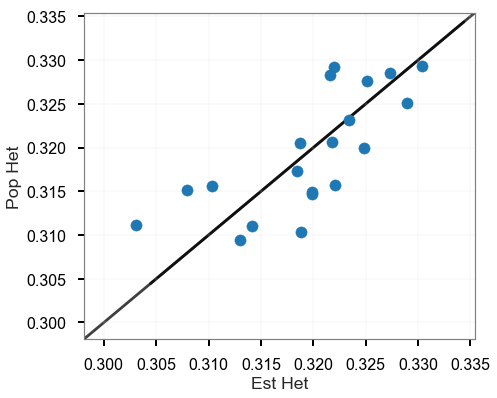

In [24]:
sim.plot_xy(model_df["Est Het"], model_df["Pop Het"])
plt.xlabel("Est Het");
plt.ylabel("Pop Het");

# compute correlation
np.corrcoef(model_df["Est Het"], model_df["Pop Het"])[0,1]

Here are the fitted kernal parameters

In [25]:
model.kern

Exponential.,value,constraints,priors
variance,0.025689483437555456,+ve,
lengthscale,63787.87800104321,+ve,


In [ ]:
lengthscale = model.kern.lengthscale[0]

It seems the GP does provides a better fit than just the naive approach of computing the MLE of heterozygosity from the genotypes!

### Effect of the lengthscale

Lets try running the simulation with fewer SNPs

In [39]:
p = 2000 # number of SNPs
n_e = 5000 # effective population size
max_gen = 700 # number of generations to sim 700*25 17500
F = sim.simulate_frequencies(p, n_e, max_gen)

n = 20
t = np.sort(np.random.choice(range(F.shape[0]), size=n, replace=False))
X = sim.simulate_genotypes(t, F)
h_hat = sim.est_het_geno(X)

In [40]:
#kern = gp.kern.Matern52(1) # set the kernal
kern = gp.kern.Exponential(1)
model = gp.models.GPRegression(t[:,None], h_hat[:,None], kern) # set the model

# fixing the noise variance
h_mod = H[-1,:]
sigma2_e = np.sum(h_mod * (1. - h_mod)) / p**2
model[".*Gaussian_noise"] = sigma2_e 
model[".*Gaussian_noise"].fix()

In [41]:
%%time
model.optimize()
model_df = pd.DataFrame({"Posterior Mean": model.posterior.mean[:,0], "Pop Het":h, "Est Het": h_hat})

CPU times: user 88.6 ms, sys: 1.21 ms, total: 89.8 ms
Wall time: 89.8 ms


 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


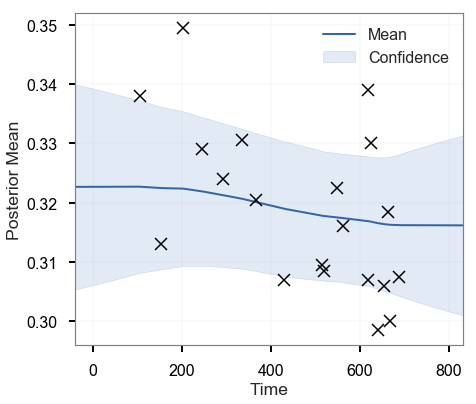

In [42]:
model.plot_f();
plt.xlabel("Time");
plt.ylabel("Posterior Mean");
plt.plot(t, h_hat,'kx',mew=1.5)

0.9695876580317494

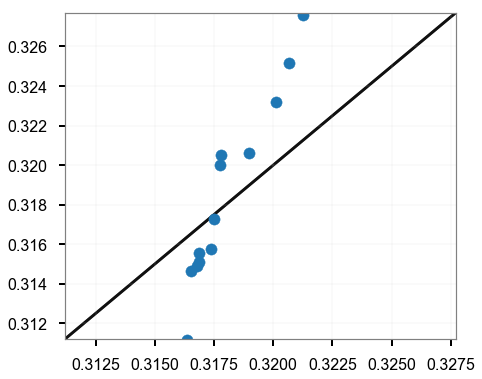

In [43]:
sim.plot_xy(model_df["Posterior Mean"], model_df["Pop Het"])
np.corrcoef(model_df["Posterior Mean"], model_df["Pop Het"])[0,1]

0.5453470033953609

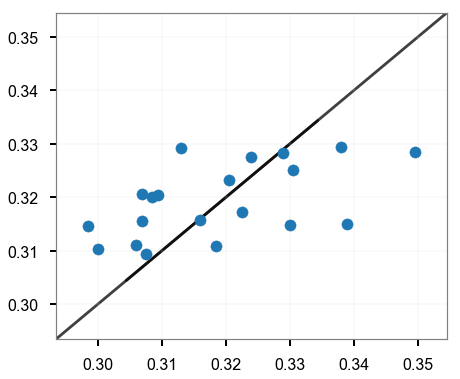

In [44]:
sim.plot_xy(model_df["Est Het"], model_df["Pop Het"])
np.corrcoef(model_df["Est Het"], model_df["Pop Het"])[0,1]

Now lets try fixing the lengthscale to $12 N_e$

In [45]:
kern = gp.kern.Exponential(1)
model = gp.models.GPRegression(t[:,None], h_hat[:,None], kern) # set the model

# fixing the noise variance
h_mod = H[-1,:]
sigma2_e = np.sum(h_mod * (1. - h_mod)) / p**2
model[".*Gaussian_noise"] = sigma2_e 
model[".*Gaussian_noise"].fix()
model[".*lengthscale"] = 12 * n_e
model[".*lengthscale"].fix()

array([0])

In [46]:
%%time
model.optimize()
model_df = pd.DataFrame({"Posterior Mean": model.posterior.mean[:,0], "Pop Het":h, "Est Het": h_hat})

CPU times: user 22.2 ms, sys: 0 ns, total: 22.2 ms
Wall time: 21.6 ms


 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


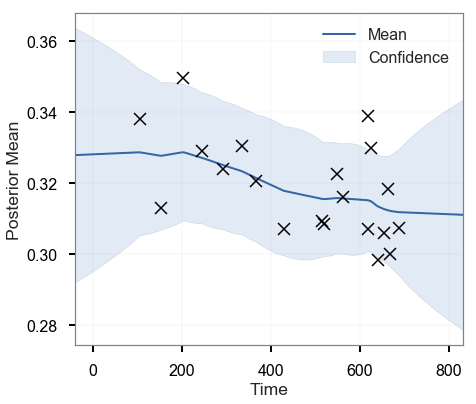

In [47]:
model.plot_f();
plt.xlabel("Time");
plt.ylabel("Posterior Mean");
plt.plot(t, h_hat,'kx',mew=1.5)

0.9629452675594136

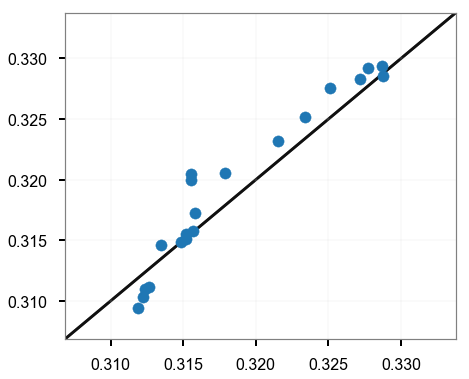

In [48]:
sim.plot_xy(model_df["Posterior Mean"], model_df["Pop Het"])
np.corrcoef(model_df["Posterior Mean"], model_df["Pop Het"])[0,1]

0.5453470033953609

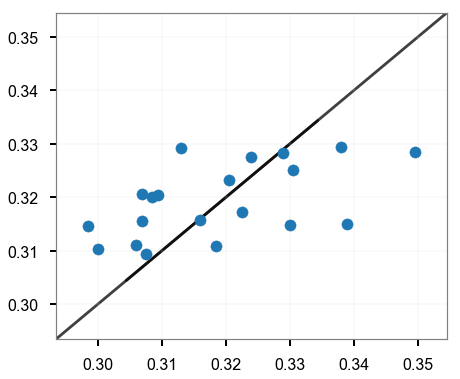

In [49]:
sim.plot_xy(model_df["Est Het"], model_df["Pop Het"])
np.corrcoef(model_df["Est Het"], model_df["Pop Het"])[0,1]